Retrieving seismic waveforms for events from previously established catalogue events.xml for stations in previously established inventory inv.xml

In [1]:
from obspy.core.inventory.inventory import read_inventory
from obspy.core.event import read_events
from obspy.clients.fdsn import Client
import os
%matplotlib notebook

Define a function to write SAC files for each trace in a folder with a name based on the eventID:

In [2]:
def write_st_as_sac(st,eventID):
    directory = './'+eventID
    if not os.path.exists(directory):
        os.makedirs(directory)
    for tr in st:
        fname = directory+"/%s.sac" % tr.id
        tr.write(fname, format="SAC")

Open the GeoNet FDSN client, from where we will get the seismic data:

In [3]:
geonetclient=Client('http://service.geonet.org.nz')

These are the events and inventory saved in the previous scripts:

In [4]:
events =read_events('https://ndownloader.figshare.com/files/7283294')
inv = read_inventory('https://ndownloader.figshare.com/files/7283279')
# get the network code from the inventory:
net = inv[0]
network = net.code

Make a list of all stations in inventory inv:

In [5]:
stations = []
for stat in net:
     stations.append(stat.code)

# this changes the station list in the format the data download needs:
bulklist= ','.join(stations)

Set length of the waveforms, nt, after earthquake origin time t0 (in seconds):

In [6]:
nt = 50

Retrieve and write data for all stations in bulklist, per event:

<IPython.core.display.Javascript object>


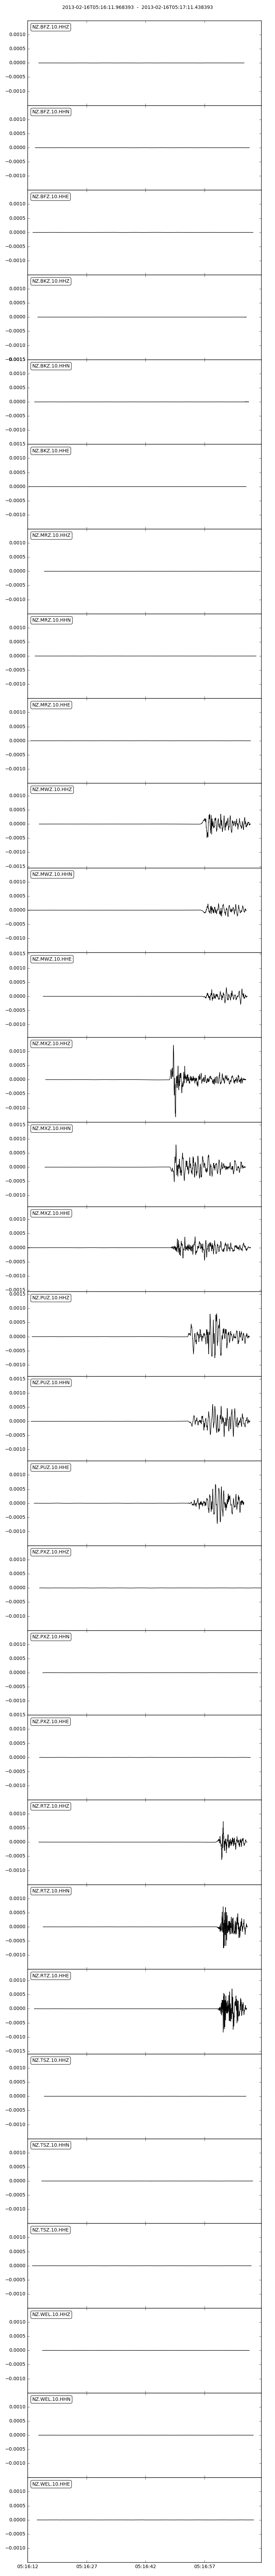

<IPython.core.display.Javascript object>


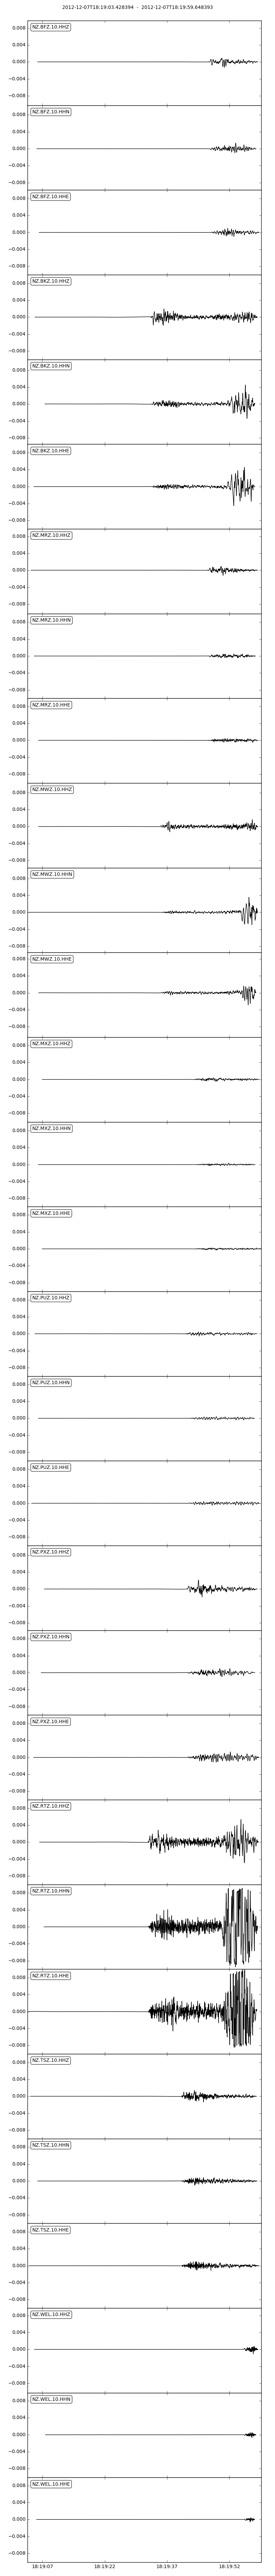

<IPython.core.display.Javascript object>


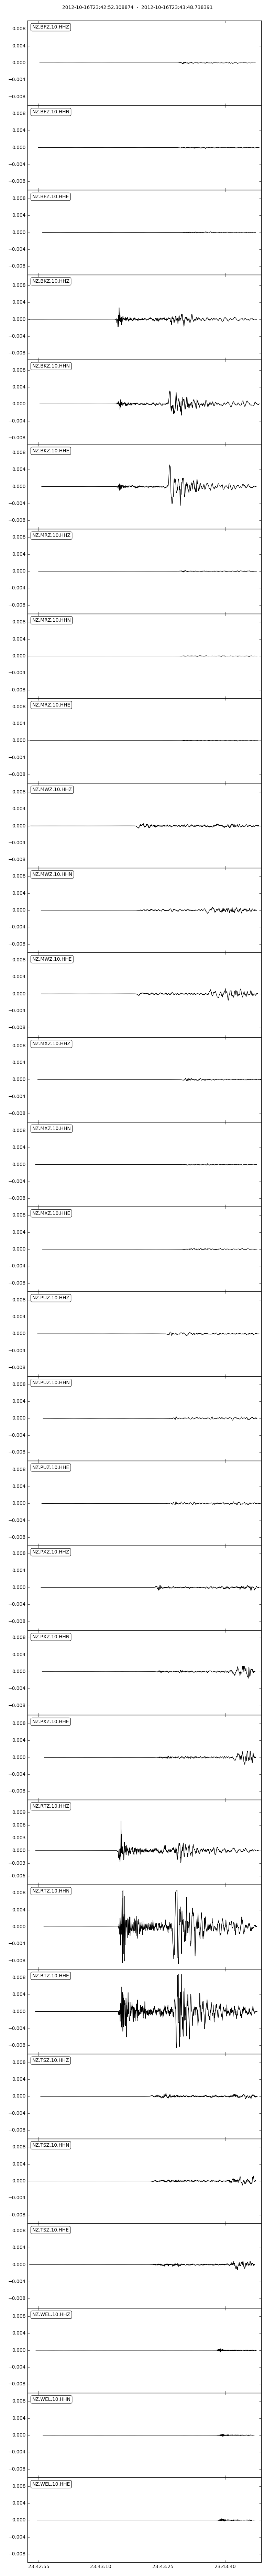

<IPython.core.display.Javascript object>


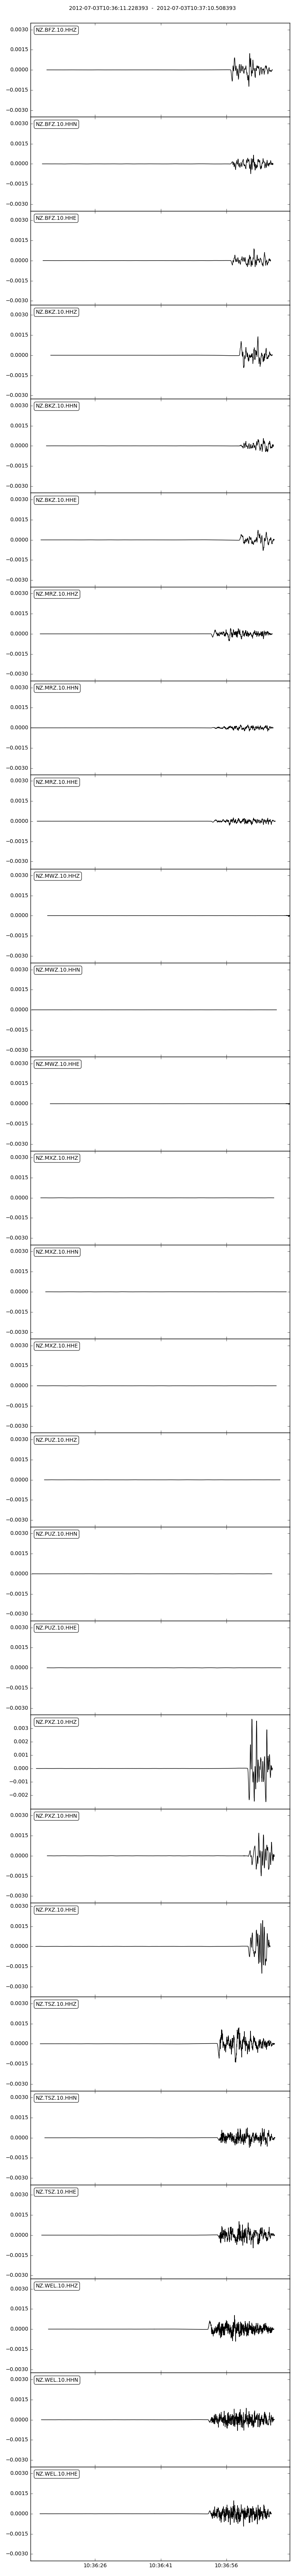

<IPython.core.display.Javascript object>


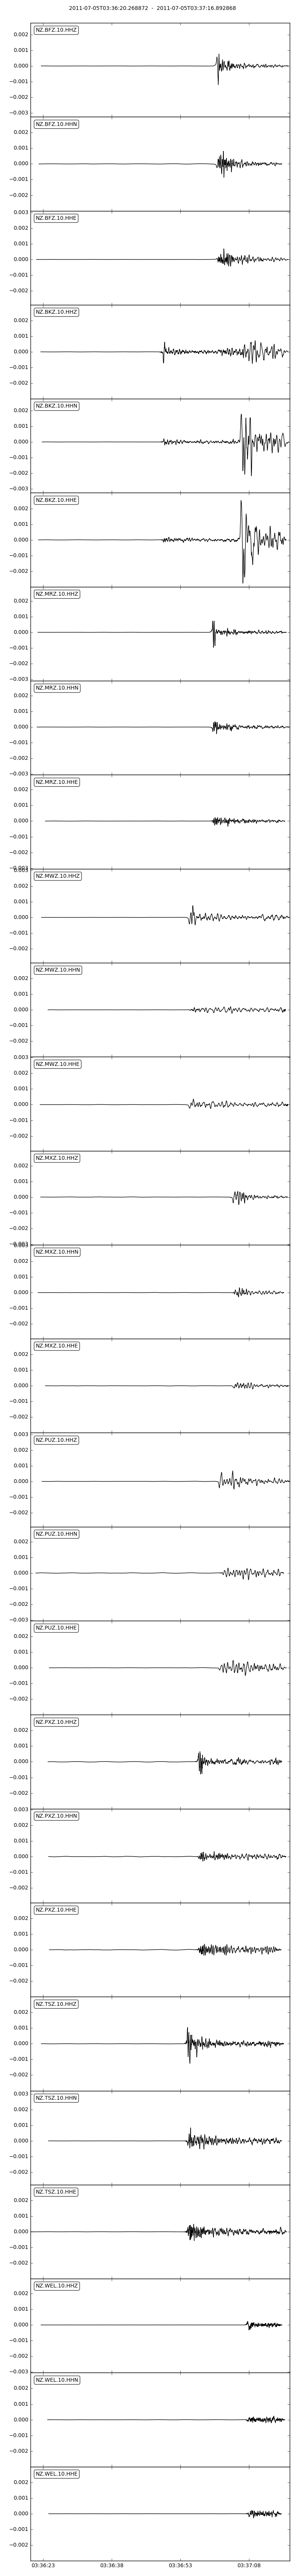

<IPython.core.display.Javascript object>


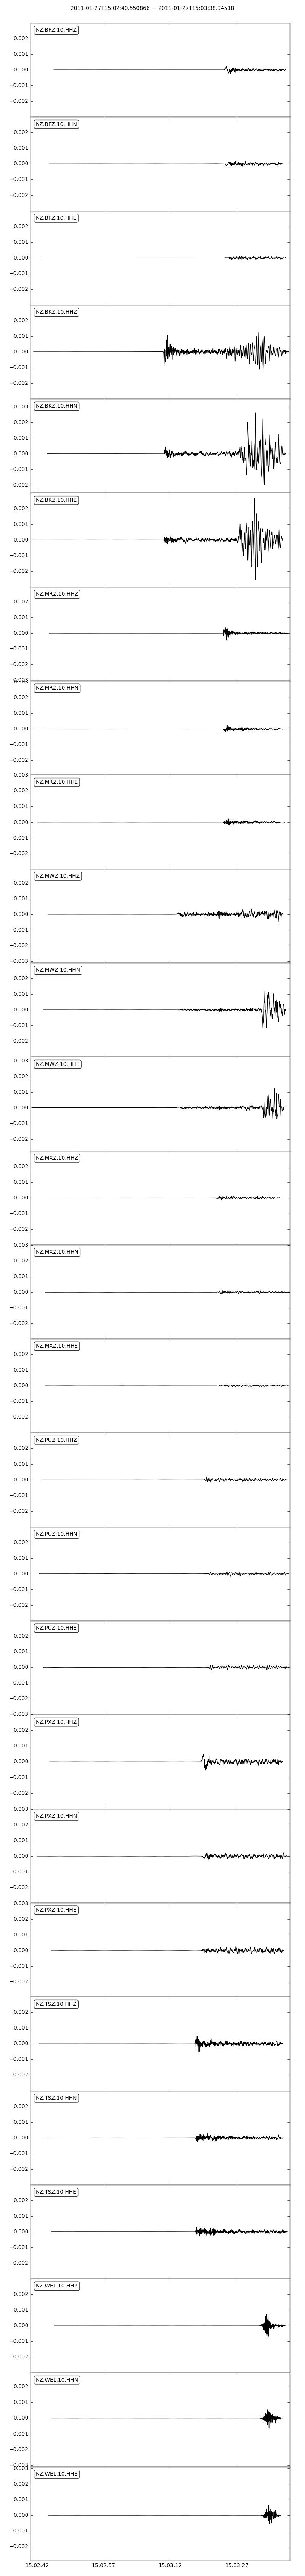

In [7]:
for event in events:
    t0=event.origins[0].time
    # I added a "try/except, for those cases there are no data for an event:    
    try:
        #To keep it simple, I assume the location is fixed, as is the component code (HHZ,N and E). 
        # This will surely break if you have variations among your stations!
        st = geonetclient.get_waveforms(network,bulklist,"10","HH*",t0,t0+nt)
    
        # you can change the trapezoidal corners of the bandpass filter
        # before the instrument response. Might need something generic, if
        # mixing broad band and short period instruments:
        pre_filt = (0.05, 0.1, 50.0, 60.0)
        # remove instrument response. output=DISP will get you displacement:
        st.remove_response(inventory=inv,output='VEL', pre_filt=pre_filt) 

        # I don't have a better way (yet) to pull the eventid number from the event:
        eventID=str(event.resource_id)[-7:]
        write_st_as_sac(st,eventID) # for SAC data
        #st.write(eventID+'.mseed',format='MSEED') # for MSEED
        st.plot()
    except:
        print('no data for event ', event.resource_id)
        continue